<a href="https://colab.research.google.com/github/aunraza19/LungsCareAI/blob/main/PreProcessing%26Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
✅ Predicted Class: covid


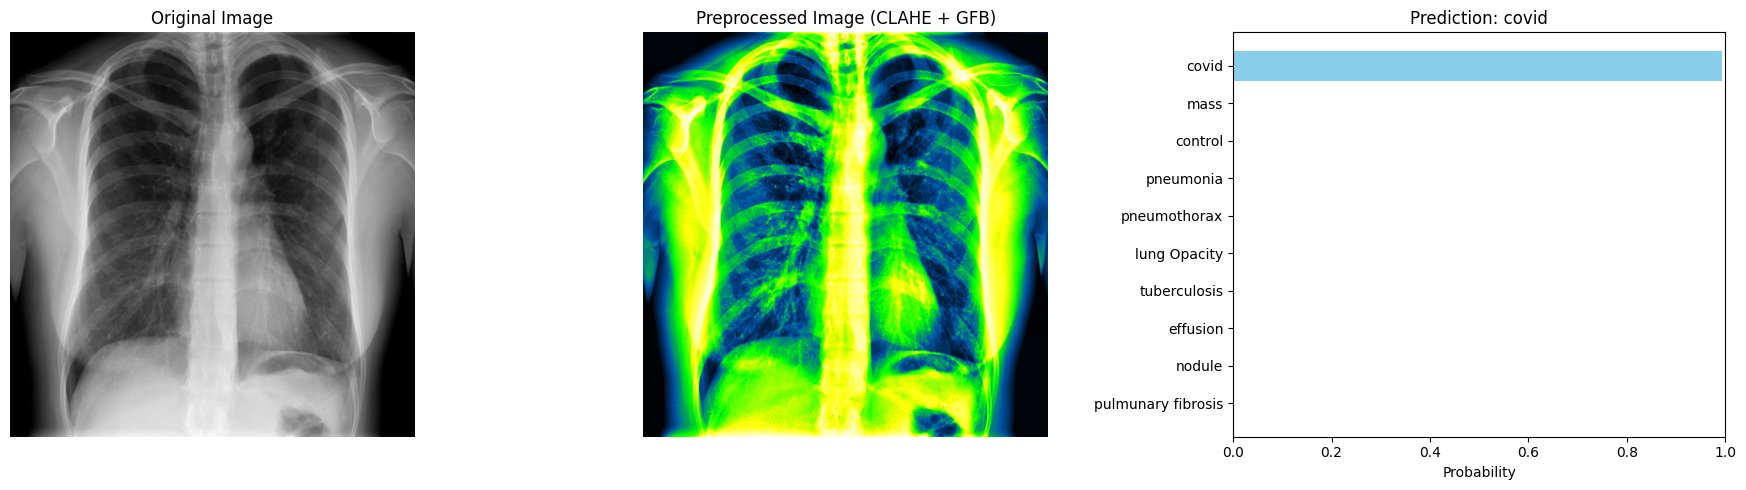

In [3]:
# EfficientNetB5 + Coordinate Attention Inference with CLAHE + GFB Visualization

import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

# Custom Coordinate Attention Layer
class CoordinateAttention(tf.keras.layers.Layer):
    def __init__(self, reduction=32, **kwargs):
        super(CoordinateAttention, self).__init__(**kwargs)
        self.reduction = reduction

    def build(self, input_shape):
        _, H, W, C = input_shape
        self.C = C
        self.conv1 = tf.keras.layers.Conv2D(max(8, C // self.reduction), 1, padding="same", use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation("relu")
        self.conv_h = tf.keras.layers.Conv2D(C, 1, padding="same", use_bias=False)
        self.conv_w = tf.keras.layers.Conv2D(C, 1, padding="same", use_bias=False)

    def call(self, x):
        h_pool = tf.reduce_mean(x, axis=1, keepdims=True)
        w_pool = tf.reduce_mean(x, axis=2, keepdims=True)
        w_pool_t = tf.transpose(w_pool, [0, 2, 1, 3])
        concat = tf.concat([h_pool, w_pool_t], axis=1)

        out = self.conv1(concat)
        out = self.bn1(out)
        out = self.act(out)

        h_out, w_out = tf.split(out, num_or_size_splits=2, axis=1)
        w_out = tf.transpose(w_out, [0, 2, 1, 3])

        h_att = tf.nn.sigmoid(self.conv_h(h_out))
        w_att = tf.nn.sigmoid(self.conv_w(w_out))

        return x * h_att * w_att


# Load Model
model = tf.keras.models.load_model(
    "/content/final_model.keras",
    custom_objects={"CoordinateAttention": CoordinateAttention},
    compile=False
)

# Load Class Indices
with open("/content/inv_class_indices.json", "r") as f:
    inv_class_indices = json.load(f)

inv_class_indices = {int(k): v for k, v in inv_class_indices.items()}


# Preprocessing Functions (CLAHE + GFB)
def load_imagej_gfb_lut(lut_path):
    with open(lut_path, 'rb') as f:
        lut_data = f.read()
    reds = np.frombuffer(lut_data[:256], dtype=np.uint8)
    greens = np.frombuffer(lut_data[256:512], dtype=np.uint8)
    blues = np.frombuffer(lut_data[512:768], dtype=np.uint8)
    return np.stack((blues, greens, reds), axis=1)  # BGR for OpenCV

GFB_LUT = load_imagej_gfb_lut("/content/Green Fire Blue.lut")

def apply_CLAHE(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def apply_GFB(img):
    gray = img if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    flat_idx = img_norm.flatten()
    colored = GFB_LUT[flat_idx]
    return colored.reshape((*img_norm.shape, 3))

def preprocess_image(img_path, target_size=(224, 224)):
    # Load original image (RGB for display)
    orig_img = image.load_img(img_path)
    img = np.array(orig_img)

    # Convert to BGR for OpenCV processing
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Step 1: CLAHE
    img = apply_CLAHE(img)

    # Step 2: GFB LUT
    img = apply_GFB(img)

    # Convert back to RGB
    preprocessed_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize for model input
    resized_img = cv2.resize(preprocessed_img, target_size)

    # Normalize for model
    x = resized_img.astype("float32") / 255.0
    x = np.expand_dims(x, axis=0)

    return orig_img, preprocessed_img, x


# Inference (Single Image)
img_path = "/content/Normal-4.png"  # change to your test image
orig_img, preprocessed_img, x = preprocess_image(img_path)

pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)[0]
pred_label = inv_class_indices[pred_class]

print(f"✅ Predicted Class: {pred_label}")

# Visualization
top_k = 10
top_indices = pred[0].argsort()[-top_k:][::-1]
top_labels = [inv_class_indices[i] for i in top_indices]
top_scores = [pred[0][i] for i in top_indices]

plt.figure(figsize=(18,5))

# Show original image
plt.subplot(1,3,1)
plt.imshow(orig_img)
plt.axis("off")
plt.title("Original Image")

# Show preprocessed image
plt.subplot(1,3,2)
plt.imshow(preprocessed_img)
plt.axis("off")
plt.title("Preprocessed Image (CLAHE + GFB)")

# Show top predictions
plt.subplot(1,3,3)
plt.barh(top_labels[::-1], top_scores[::-1], color="skyblue")
plt.xlabel("Probability")
plt.title(f"Prediction: {pred_label}")
plt.xlim(0,1)

plt.tight_layout()
plt.show()
